In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from cinnamon.drift import ModelDriftExplainer, AdversarialDriftExplainer

RANDOM_SEED = 2021

In [2]:
from sklearn.datasets import fetch_california_housing

from sklearn.datasets import fetch_openml
california = fetch_openml(name="house_prices", as_frame=True)

california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal


# California Housing Data

In [2]:
boston = datasets.load_boston()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [3]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)

In [4]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [3]:
california_df.shape

(1460, 80)

In [8]:
# checking features
california_cat = california_df.select_dtypes(include='O').keys()
# display variabels
california_cat,california_df.columns

(Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition'],
       dtype='object'),
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
        'RoofStyle',

In [9]:
# creating new df
# setting columns we use
new_df = california_df[california_cat]
new_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [10]:
# unique values in each columns
for x in new_df.columns:
    #prinfting unique values
    print(x ,':', len(new_df[x].unique()))

MSZoning : 5
Street : 2
Alley : 3
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 5
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 5
BsmtCond : 5
BsmtExposure : 5
BsmtFinType1 : 7
BsmtFinType2 : 7
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 6
KitchenQual : 4
Functional : 7
FireplaceQu : 6
GarageType : 7
GarageFinish : 4
GarageQual : 6
GarageCond : 6
PavedDrive : 3
PoolQC : 4
Fence : 5
MiscFeature : 5
SaleType : 9
SaleCondition : 6


In [17]:
# for all categorical variables we selected
import numpy as np
def top_x(df2,feature_list):
    
    for featr in feature_list:
        #df2[featr].value_counts().sort_values(ascending=False).head(20)
        top_x_labels = [x for x in df2[featr].value_counts().sort_values(ascending=False).head(20).index]
        for label in top_x_labels:
            df2[featr+'_'+label] = np.where(df2[featr]==label,1,0)
            # read the data again
            #data = california_df[california_cat]
    return df2
        

#encode Nighborhood into the 10 most frequent categories
data = top_x(california_df,list(california_cat))
california_n_cat = data.select_dtypes(include='O').keys()
print(len(data.columns), len(california_df.columns), len(california_n_cat))


data = data.drop(columns = list(california_cat))
# display data
data.head()


327 327 43


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_CWD,SaleType_Oth,SaleType_Con,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_AdjLand
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,0,0,0,0,1,0,0,0,0,0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,0,0,0,0,1,0,0,0,0,0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0,0,0,0,0,0,1,0,0,0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
print(len(data.columns), data.columns)
california.target

284 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_ConLw', 'SaleType_CWD', 'SaleType_Oth', 'SaleType_Con',
       'SaleCondition_Normal', 'SaleCondition_Partial',
       'SaleCondition_Abnorml', 'SaleCondition_Family', 'SaleCondition_Alloca',
       'SaleCondition_AdjLand'],
      dtype='object', length=284)


0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

# Build XGBoost model

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, california.target, test_size=0.3, random_state=RANDOM_SEED)

In [34]:
model = XGBRegressor(n_estimators=1000,
                   booster="gbtree",
                   objective="reg:squarederror",
                   learning_rate=0.05,
                   max_depth=6,
                   seed=RANDOM_SEED,
                   use_label_encoder=False)

In [35]:
model.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=10)

[0]	validation_0-rmse:183919.14062
[10]	validation_0-rmse:114069.06250
[20]	validation_0-rmse:73334.18750
[30]	validation_0-rmse:50191.04688
[40]	validation_0-rmse:37219.70312
[50]	validation_0-rmse:30297.32617
[60]	validation_0-rmse:27040.36133
[70]	validation_0-rmse:25455.99414
[80]	validation_0-rmse:24667.10156
[90]	validation_0-rmse:24248.75000
[100]	validation_0-rmse:24068.95898
[110]	validation_0-rmse:23940.35742
[120]	validation_0-rmse:23847.82227
[130]	validation_0-rmse:23756.42578
[140]	validation_0-rmse:23647.43359
[150]	validation_0-rmse:23583.20312
[160]	validation_0-rmse:23553.37500
[170]	validation_0-rmse:23523.86719
[180]	validation_0-rmse:23502.40625
[190]	validation_0-rmse:23468.20117
[200]	validation_0-rmse:23433.28320
[210]	validation_0-rmse:23407.91211
[220]	validation_0-rmse:23396.89453
[230]	validation_0-rmse:23375.89648
[240]	validation_0-rmse:23350.71094
[250]	validation_0-rmse:23332.98242
[260]	validation_0-rmse:23310.51953
[270]	validation_0-rmse:23306.98047
[

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1,
             random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=2021, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=None)

# ModelDriftExplainer

The experiment is done with a random split so we should not detect a data drift

In [36]:
drift_explainer = ModelDriftExplainer(model)

In [37]:
drift_explainer.fit(X_train, X_test, y_train, y_test)

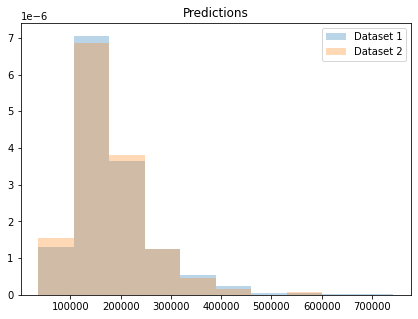

[DriftMetricsNum(mean_difference=-5645.511641032703, wasserstein=6563.151030200176, ks_test=BaseStatisticalTestResult(statistic=0.046966731898238745, pvalue=0.4943709245152732))]

In [38]:
# no apparent drift in distributions of predictions
drift_explainer.plot_prediction_drift()
drift_explainer.get_prediction_drift()

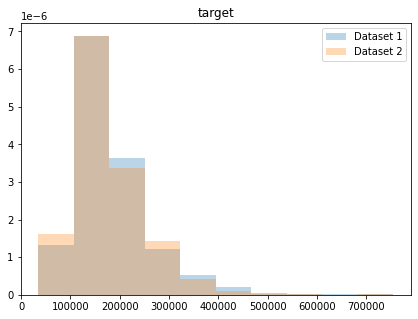

DriftMetricsNum(mean_difference=-5589.04044357469, wasserstein=6036.554468362687, ks_test=BaseStatisticalTestResult(statistic=0.04044357469015003, pvalue=0.6829578717438207))

In [39]:
# no apparent drift in distributions of target labels
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [40]:
# here we would detect a data drift but the difference in performance metrics
# is due to comparing train and test dataset
drift_explainer.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=RegressionMetrics(mse=10567733.794917172, explained_variance=0.9983637108518892), dataset2=RegressionMetrics(mse=540758766.1766539, explained_variance=0.9088298308495063))

In [45]:
drift_explainer.get_feature_drift(0)

DriftMetricsNum(mean_difference=-2.8180039138942448, wasserstein=10.854533594259623, ks_test=BaseStatisticalTestResult(statistic=0.02674494455316373, pvalue=0.9768320613309149))

In [46]:
drift_explainer.get_feature_drifts()

[DriftMetricsNum(mean_difference=-2.8180039138942448, wasserstein=10.854533594259623, ks_test=BaseStatisticalTestResult(statistic=0.02674494455316373, pvalue=0.9768320613309149)),
 DriftMetricsNum(mean_difference=2.75277234181344, wasserstein=3.1898238747553824, ks_test=BaseStatisticalTestResult(statistic=0.043052837573385516, pvalue=0.6059985408620029)),
 DriftMetricsNum(mean_difference=nan, wasserstein=nan, ks_test=BaseStatisticalTestResult(statistic=0.04827136333985649, pvalue=0.4592384008406269)),
 DriftMetricsNum(mean_difference=-677.3701891715591, wasserstein=799.1373124592303, ks_test=BaseStatisticalTestResult(statistic=0.042400521852576645, pvalue=0.6251891675104069)),
 DriftMetricsNum(mean_difference=-0.11904761904761862, wasserstein=0.11904761904761899, ks_test=BaseStatisticalTestResult(statistic=0.03065883887801696, pvalue=0.9272829513531501)),
 DriftMetricsNum(mean_difference=-0.08153946510110899, wasserstein=0.08153946510110893, ks_test=BaseStatisticalTestResult(statistic=

# AdversarialDriftExplainer

In [47]:
# logs corresponds training logs of adversarial classifiers
drift_explainer2 = AdversarialDriftExplainer(seed=RANDOM_SEED).fit(X_train, X_test, y_train, y_test)

[0]	validation_0-error:0.47518	validation_0-auc:0.53427	validation_0-logloss:0.69149
[10]	validation_0-error:0.48073	validation_0-auc:0.54071	validation_0-logloss:0.69963
[20]	validation_0-error:0.47355	validation_0-auc:0.54010	validation_0-logloss:0.71242
[21]	validation_0-error:0.47551	validation_0-auc:0.53999	validation_0-logloss:0.71303
[0]	validation_0-error:0.46026	validation_0-auc:0.54436	validation_0-logloss:0.69096
[10]	validation_0-error:0.47036	validation_0-auc:0.54273	validation_0-logloss:0.69758
[20]	validation_0-error:0.47134	validation_0-auc:0.54161	validation_0-logloss:0.71051
[23]	validation_0-error:0.48143	validation_0-auc:0.53288	validation_0-logloss:0.72037


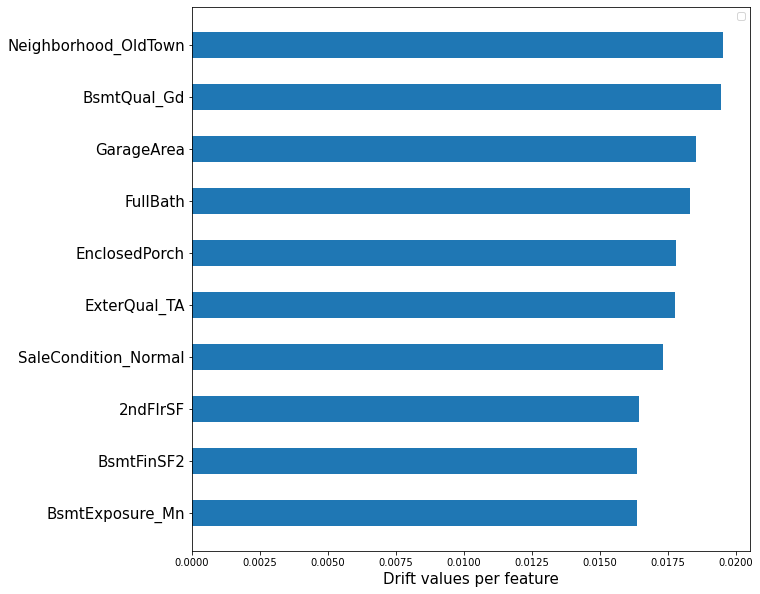

array([[0.01470508],
       [0.01394766],
       [0.01414003],
       [0.01480855],
       [0.01510309],
       [0.01051923],
       [0.0159347 ],
       [0.0147691 ],
       [0.01383765],
       [0.0162506 ],
       [0.01636611],
       [0.01453401],
       [0.01266923],
       [0.01216766],
       [0.01643143],
       [0.        ],
       [0.01375481],
       [0.01064079],
       [0.        ],
       [0.01829235],
       [0.01295415],
       [0.01471711],
       [0.        ],
       [0.01284571],
       [0.00436892],
       [0.01201828],
       [0.01159294],
       [0.01850999],
       [0.01570245],
       [0.01590939],
       [0.01778149],
       [0.        ],
       [0.00832283],
       [0.        ],
       [0.        ],
       [0.01224979],
       [0.01086823],
       [0.        ],
       [0.        ],
       [0.00569078],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00478663],
       [0.        ],
       [0.01450049],
       [0.   

In [48]:
# plot drift values computed with the adversarial approach
drift_explainer2.plot_adversarial_drift_values()
drift_explainer2.get_adversarial_drift_values()

In [49]:
drift_explainer2.get_feature_drifts()

[DriftMetricsNum(mean_difference=-2.8180039138942448, wasserstein=10.854533594259623, ks_test=BaseStatisticalTestResult(statistic=0.02674494455316373, pvalue=0.9768320613309149)),
 DriftMetricsNum(mean_difference=2.75277234181344, wasserstein=3.1898238747553824, ks_test=BaseStatisticalTestResult(statistic=0.043052837573385516, pvalue=0.6059985408620029)),
 DriftMetricsNum(mean_difference=nan, wasserstein=nan, ks_test=BaseStatisticalTestResult(statistic=0.04827136333985649, pvalue=0.4592384008406269)),
 DriftMetricsNum(mean_difference=-677.3701891715591, wasserstein=799.1373124592303, ks_test=BaseStatisticalTestResult(statistic=0.042400521852576645, pvalue=0.6251891675104069)),
 DriftMetricsNum(mean_difference=-0.11904761904761862, wasserstein=0.11904761904761899, ks_test=BaseStatisticalTestResult(statistic=0.03065883887801696, pvalue=0.9272829513531501)),
 DriftMetricsNum(mean_difference=-0.08153946510110899, wasserstein=0.08153946510110893, ks_test=BaseStatisticalTestResult(statistic=

In [51]:
drift_explainer2.get_feature_drift('Neighborhood_OldTown')

DriftMetricsNum(mean_difference=-0.022504892367906065, wasserstein=0.022504892367906093, ks_test=BaseStatisticalTestResult(statistic=0.022504892367906065, pvalue=0.996919812985332))

In [52]:
drift_explainer2.get_feature_drift(0)

DriftMetricsNum(mean_difference=-2.8180039138942448, wasserstein=10.854533594259623, ks_test=BaseStatisticalTestResult(statistic=0.02674494455316373, pvalue=0.9768320613309149))